In [123]:
import os
import sys
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

prj_dir = os.path.abspath(os.getcwd() + '/..')
print(prj_dir)
sys.path.append(prj_dir)

/Users/omarolivares/Documents/DataMexico/rulo_mota_omath


In [124]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
import shap
from sklearn.model_selection import train_test_split

from src import config
from src.features import X_features
from src.features import banxico_mun_income_remittances

In [203]:
path = os.path.join(
    config.PRJ_DIR,
    'data/processed/X.csv')

data = pd.read_csv(path)
data.set_index('id', inplace=True)

remittances = banxico_mun_income_remittances.get()

[15:21:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "scale_pos_weigh" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:21:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


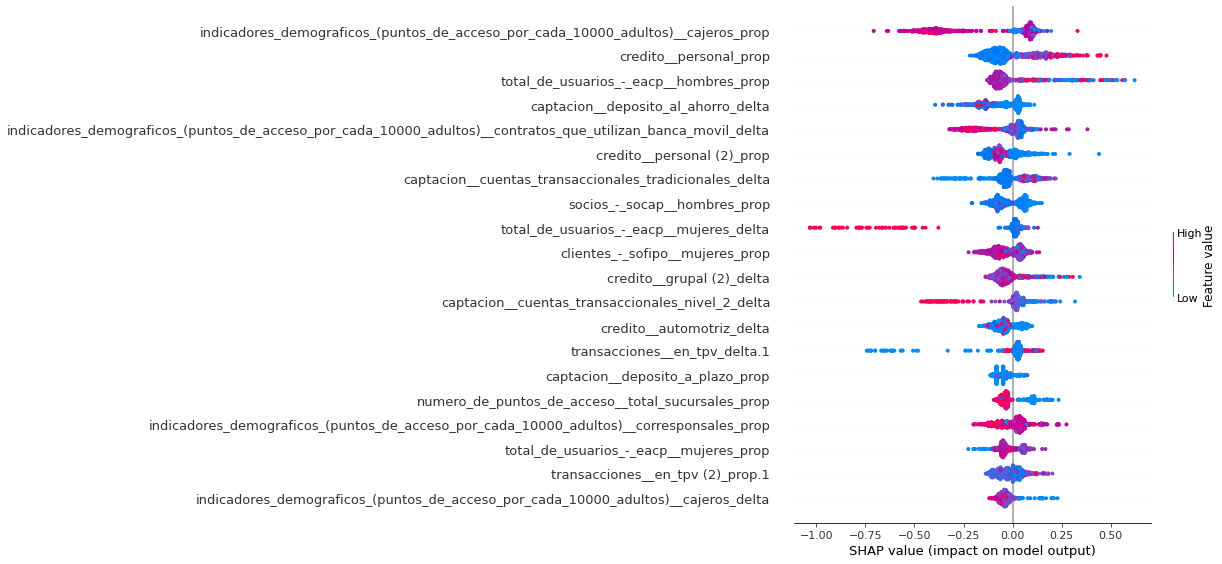

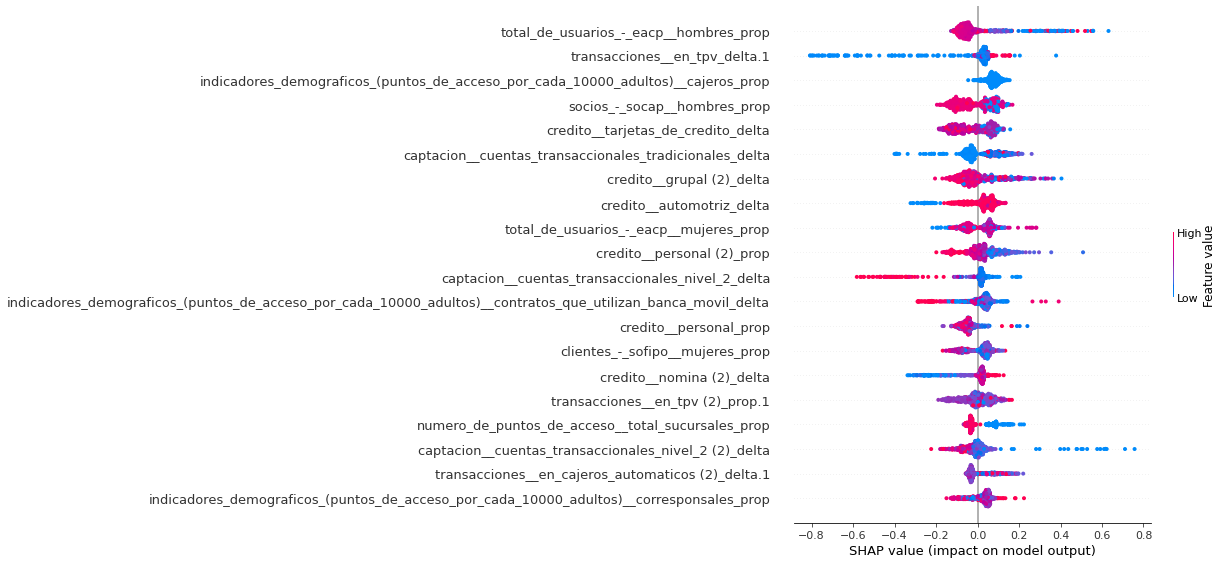

In [252]:
feature_importance, shap_cache = {}, {}

X = data.drop(['year','year.1','year.2'], axis=1)
   
year = '2019-2020'
year_remittances = remittances
y = year_remittances['is_change_neg_at_5']
y = y.astype(int)

valid_ids = list(set(X.index).intersection(year_remittances.index))

X, y = X.loc[valid_ids], y.loc[valid_ids]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=.5)

model = XGBClassifier(
    learning_rate=0.1, 
    max_depth=4, 
    n_estimators=100,
    scale_pos_weigh = 7.367816091954023)

model.fit(
    X.values, y, 
    eval_set=[
        (X_test.values, y_test)
    ],
    early_stopping_rounds=20,
    verbose=False)

explainer = shap.TreeExplainer(model)


######################################

year_2019 = remittances[remittances['Year'] == 2019]
year_2020 = remittances[remittances['Year'] == 2020]

valid_ids = list(set(X_test.index).intersection(year_2019.index))
X_2019 = X_test.loc[valid_ids]

valid_ids = list(set(X_test.index).intersection(year_2020.index))
X_2020 = X_test.loc[valid_ids]


shap_values = explainer.shap_values(
    X_2019, 
    check_additivity=False)

features_shap_values = pd.DataFrame(
    shap_values,
    columns=X_test.columns)

features_shap_values_contribution = features_shap_values.abs().sum()

feature_importance[year] = features_shap_values_contribution
shap.summary_plot(
    shap_values, 
    X_2019, 
    max_display=20)


shap_values = explainer.shap_values(
    X_2020, 
    check_additivity=False)

features_shap_values = pd.DataFrame(
    shap_values,
    columns=X_test.columns)

features_shap_values_contribution = features_shap_values.abs().sum()

feature_importance[year] = features_shap_values_contribution
shap.summary_plot(
    shap_values, 
    X_2020, 
    max_display=20)


In [241]:
import seaborn as sns

In [242]:
preds = model.predict_proba(X_test)[:,1]

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:ylabel='Density'>

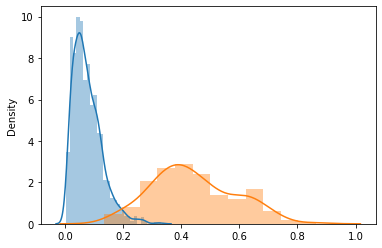

In [243]:
sns.distplot(preds[y_test == 0])
sns.distplot(preds[y_test == 1])

In [247]:
year_remittances = remittances[remittances['Year']==2020]
y = year_remittances['is_change_neg_at_5']
y = y.astype(int)

X = data.drop(['year','year.1','year.2'], axis=1)
valid_ids = list(set(X.index).intersection(year_remittances.index))

X, y = X.loc[valid_ids], y.loc[valid_ids]

In [248]:
preds = model.predict_proba(X)[:,1]

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:ylabel='Density'>

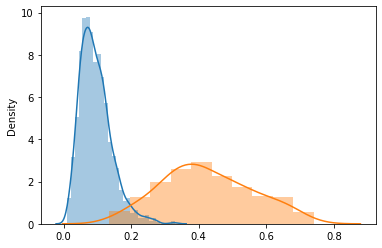

In [249]:
sns.distplot(preds[y == 0])
sns.distplot(preds[y == 1])

In [265]:
shap_values_2019 = explainer.shap_values(
    X_2019, 
    check_additivity=False)

shap_values_2020 = explainer.shap_values(
    X_2020, 
    check_additivity=False)

shaps_2019 = pd.DataFrame(shap_values_2019, columns=X_train.columns)
shaps_2020 = pd.DataFrame(shap_values_2020, columns=X_train.columns)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


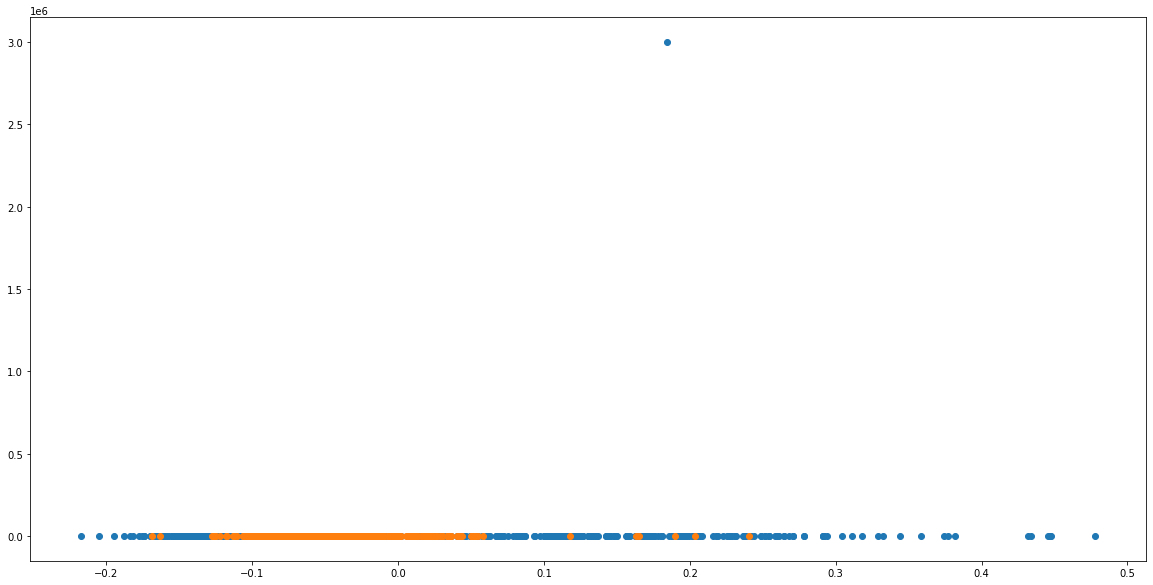

In [283]:
fig, ax = plt.subplots(1,1 ,figsize=(20,10))
plt.scatter(shaps_2019['credito__personal_prop'], X_2019['credito__personal_prop'])
plt.scatter(shaps_2020['credito__personal_prop'], X_2020['credito__personal_prop'])

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='credito__personal_prop', ylabel='Density'>

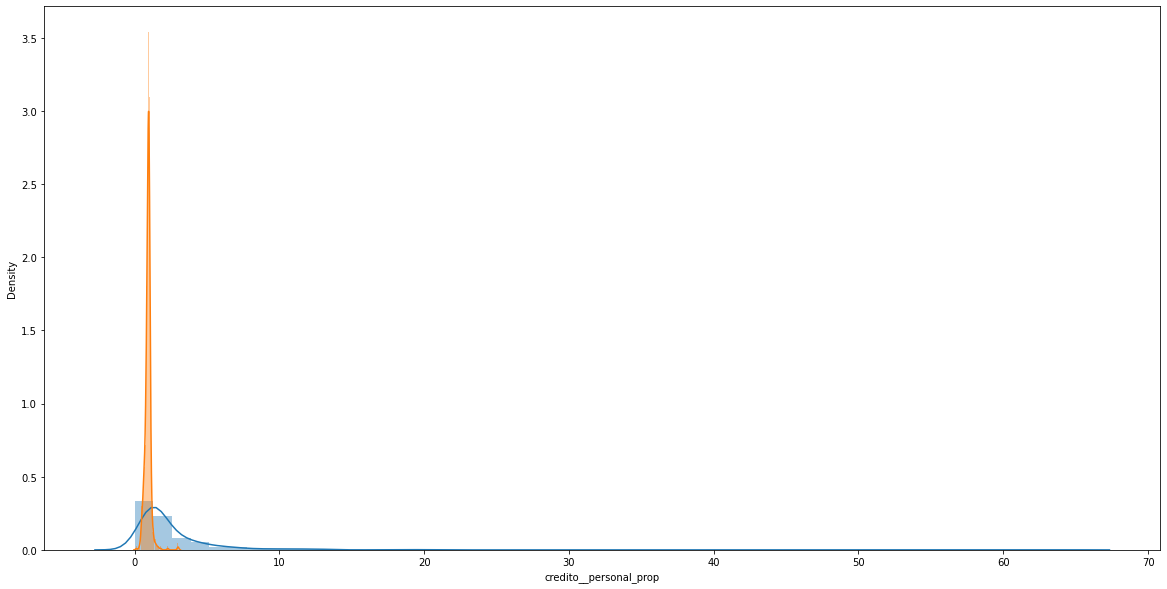

In [299]:
fig, ax = plt.subplots(1,1 ,figsize=(20,10))
sns.distplot(X_2019[X_2019['credito__personal_prop']<2000]['credito__personal_prop'])
sns.distplot(X_2020[X_2020['credito__personal_prop']<2000]['credito__personal_prop'])

In [300]:
X_2019['credito__personal_prop']

id
21209-2019     4.781818
12045-2019     0.766284
20043-2019     0.742090
30132-2019     1.960595
15110-2019     0.990152
                ...    
13074-2019     0.612858
20197-2019    10.485714
21025-2019     4.595745
21051-2019     1.214449
12058-2019     1.205559
Name: credito__personal_prop, Length: 753, dtype: float64